In [1]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [6]:
def wrangle(filepath):
     # Read CSV file into Dataframe
    df_dt = pd.read_csv(filepath)
    
    # Drop features with high null counts
    df_dt.drop(columns=["Curb Cut", "Horizontal Enlrgmt", "Vertical Enlrgmt"], inplace=True)
    
    # Remove NAN Value
    df_dt.dropna(inplace=True)
    
    # Transform 'Initial Cost from object to float
    df_dt['Initial Cost'] = df_dt['Initial Cost'].apply(lambda x: float(x.replace('$','').replace(',','')))
    
    df_dt.drop(['Block','Bin #','Community - Board',
               'Fully Permitted','Enlargement SQ Footage',
               'Job Description','House #',
               'Street Name'],axis = 1, inplace = True)
    
    
    return df_dt

In [7]:
df_dt = wrangle(r"C:\Users\sanus\Desktop\DS\web\apartment_cost_list.csv")
print(df_dt.info())
df_dt.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14823 entries, 1 to 19610
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Job #                 14823 non-null  int64  
 1   Borough               14823 non-null  object 
 2   Lot                   14823 non-null  int64  
 3   Job Type              14823 non-null  object 
 4   Initial Cost          14823 non-null  float64
 5   Proposed Zoning Sqft  14823 non-null  int64  
 6   Zoning Dist1          14823 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 926.4+ KB
None


,Job #,Borough,Lot,Job Type,Initial Cost,Proposed Zoning Sqft,Zoning Dist1
1,140922893,MANHATTAN,43,A2,85000.0,0,R8B
2,301773579,BROOKLYN,86,A1,60000.0,0,R6
4,301989276,BROOKLYN,10,A1,40000.0,0,C4-3


# Split data

In [8]:
target = "Initial Cost"
features = ["Borough"]
y_train = df_dt[target]
X_train = df_dt[features]

In [9]:
# Check your work
assert X_train.shape == (14823, 1), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (14823,), f"`y_train` is the wrong size: {y_train.shape}."

# Build Model¶
# Baseline

In [11]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean Initial Cost:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean Initial Cost: 59641.907845915135
Baseline MAE: 13246.892749315202


# Iterate

In [12]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    #LinearRegression()
    Ridge()
    
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Borough'], use_cat_names=True)),
                ('ridge', Ridge())])

In [13]:
# Check your work
check_is_fitted(model[-1])

# Evaluate

In [15]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([59459.37448918, 60075.75227323, 60075.75227323, 60075.75227323,
       60075.75227323])

In [14]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 13291.5


# Communicate Results

In [16]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficien

coefficients len: 5
[-1165.88564775  -549.50786371  4428.65541289 -2188.97330824
  -524.28859321]


In [17]:
# Check your work
assert isinstance(
    intercept, float
), f"`intercept` should be a `float`, not {type(intercept)}."
assert isinstance(
    coefficients, np.ndarray
), f"`coefficients` should be a `float`, not {type(coefficients)}."
assert coefficients.shape == (
    5,
), f"`coefficients` is wrong shape: {coefficients.shape}."

In [18]:
feature_names = model.named_steps["onehotencoder"].get_feature_names() 
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 5
['Borough_MANHATTAN', 'Borough_BROOKLYN', 'Borough_BRONX', 'Borough_QUEENS', 'Borough_STATEN ISLAND']


In [19]:
# Check your work
assert isinstance(
    feature_names, list
), f"`features` should be a `list`, not {type(features)}."
assert len(feature_names) == len(
    coefficients
), "You should have the same number of features and coefficients."

In [20]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

Borough_MANHATTAN       -1165.885648
Borough_BROOKLYN         -549.507864
Borough_BRONX            4428.655413
Borough_QUEENS          -2188.973308
Borough_STATEN ISLAND    -524.288593
dtype: float64

In [21]:
# Check your work
assert isinstance(
    feat_imp, pd.Series
), f"`feat_imp` should be a `float`, not {type(feat_imp)}."
assert feat_imp.shape == (5,), f"`feat_imp` is wrong shape: {feat_imp.shape}."
assert all(
    a == b for a, b in zip(sorted(feature_names), sorted(feat_imp.index))
), "The index of `feat_imp` should be identical to `features`."

In [22]:
print(f"Initial Cost = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

Initial Cost = 60625.26
+ (-1165.89 * Borough_MANHATTAN)
+ (-549.51 * Borough_BROOKLYN)
+ (4428.66 * Borough_BRONX)
+ (-2188.97 * Borough_QUEENS)
+ (-524.29 * Borough_STATEN ISLAND)


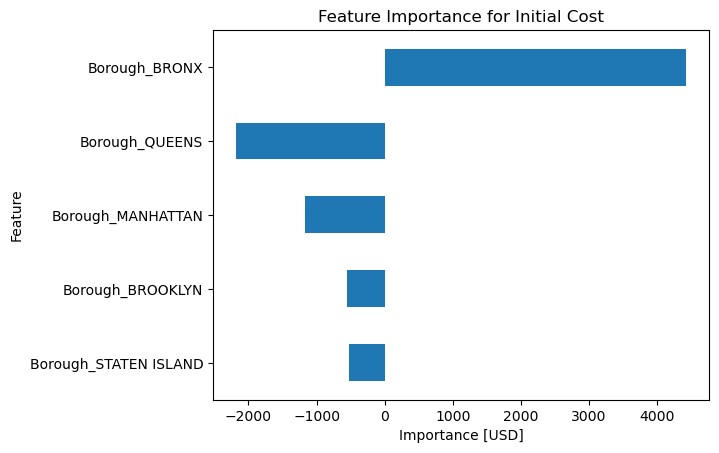

In [23]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Initial Cost");

Looking at this bar chart, we can see that the poshest Borough in New York like {BRONX} increase the predicted price of an apartment, while more working-class Borough like {STATEN ISLAND} and {QUEENS} decrease the predicted price

